# Partitioning feature space

In [1]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.datasets import load_boston, load_iris, load_wine, load_digits, \
                             load_breast_cancer, load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

from sklearn import tree
from dtreeviz.trees import *
from dtreeviz.models.shadow_decision_tree import ShadowDecTree

In [2]:
def show_mse_leaves(X,y,max_depth):
    t = DecisionTreeRegressor(max_depth=max_depth)
    t.fit(X,y)
    shadow = ShadowDecTree.get_shadow_tree(t, X, y, feature_names=['sqfeet'], target_name='rent')
    root, leaves, internal = shadow._get_tree_nodes()
    # node2samples = shadow._get_tree_nodes()_samples()
    # isleaf = shadow.get_node_type(t)
    n_node_samples = t.tree_.n_node_samples

    mse = 99.9#mean_squared_error(y, [np.mean(y)]*len(y))
    print(f"Root {0:3d} has {n_node_samples[0]:3d} samples with MSE ={mse:6.2f}")
    print("-----------------------------------------")

    avg_mse_per_record = 0.0
    node2samples = shadow.get_node_samples()
    for node in leaves:
        leafy = y[node2samples[node.id]]
        n = len(leafy)
        mse = mean_squared_error(leafy, [np.mean(leafy)]*n)
        avg_mse_per_record += mse * n
        print(f"Node {node.id:3d} has {n_node_samples[node.id]:3d} samples with MSE ={mse:6.2f}")

    avg_mse_per_record /= len(y)
    print(f"Average MSE per record is {avg_mse_per_record:.1f}")

**Make sure to get latest dtreeviz**

`pip install -U dtreeviz`

## Regression

In [3]:
df_cars = pd.read_csv("data/cars.csv")
X, y = df_cars[['ENG']], df_cars['MPG']
df_cars.head(3)

,MPG,CYL,ENG,WGT
0,18.0,8,307.0,3504
1,15.0,8,350.0,3693
2,18.0,8,318.0,3436


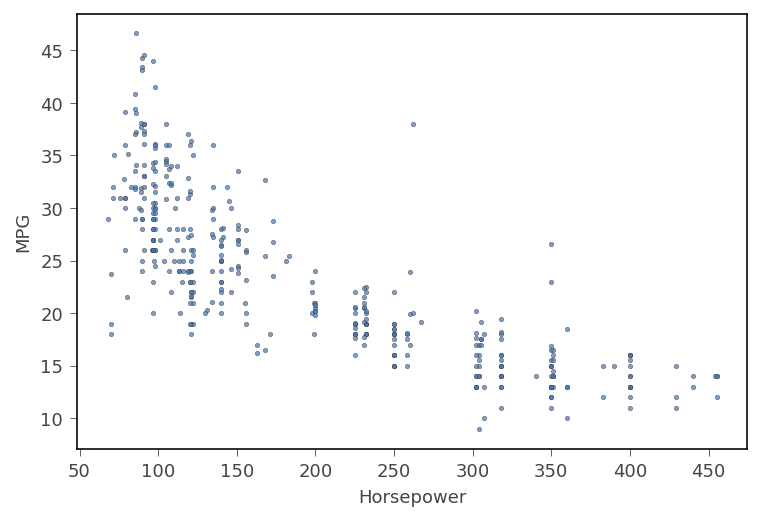

In [4]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X, y)

rtreeviz_univar(dt, X, y,
                feature_names='Horsepower',
                markersize=5,
                mean_linewidth=1,
                target_name='MPG',
                fontsize=9,
                show={})

**Q.** What is the MSE between y and predicted $\hat{y} = \overline{y}$?

Hints: You can use function `mean_squared_error(` $y$,$\hat{y}$ `)`; create a vector of length $|y|$ with $\overline{y}$ as elements.

<details>
<summary>Solution</summary>
<pre>
mean_squared_error(y, [np.mean(y)]*len(y)) # about 60.76
</pre>
</details>

**Q.** Where would you split this if you could only split once?  Set the `split` variable to a reasonable value.

In [5]:
split = ...

<details>
<summary>Solution</summary>
The split location that gets most pure subregion might be about split = 200 HP because the region to the right has a relatively flat MPG average.
</details>

**Alter the rtreeviz_univar() call to show the split with arg show={'splits'}**

<details>
    <summary>Solution</summary>
<pre>
rtreeviz_univar(dt, X, y,
                feature_names='Horsepower',
                markersize=5,
                mean_linewidth=1,
                target_name='MPG',
                fontsize=9,
                show={'splits'})
</pre>
</details>

**Q.** What are the MSE values for the left, right partitions?

Hints: Get the y values whose `X['ENG']` are less than `split` into `lefty` and those greater than or equal to `split` into `righty`.  The split introduces two new children that are leaves until we (possibly) split them; the leaves predict the mean of their samples.

In [6]:
lefty = ...;   mleft = ...
righty = ...; mright = ...

mse_left = ...
mse_right = ...

mse_left, mse_right

(Ellipsis, Ellipsis)

<details>
<summary>Solution</summary>
    Should be (35.68916307096633, 12.770261374699789)<p>
<pre>
lefty = y[X['ENG']<split]
righty = y[X['ENG']>=split]
mleft = np.mean(lefty)
mright = np.mean(righty)

mse_left = mean_squared_error(lefty, [mleft]\*len(lefty))
mse_right = mean_squared_error(righty, [mright]\*len(righty))
</pre>
</details>

**Q.** Compare the MSE values for overall y and the average of the left, right partition MSEs (which is about 24.2)?

<details>
<summary>Solution</summary>
After the split the MSE of the children is much lower than before the split, therefore, it is a worthwhile split.
</details>


**Q.** Set the split value to 100 and recompare MSE values for y, left, and right.

<details>
<summary>Solution</summary>
With split=100, mse_left, mse_right become 33.6 and 41.0. These are still less than the y MSE of 60.7 so worthwhile but not nearly as splitting at 200.
</details>


### Effect of deeper trees

Consider the sequence of tree depths 1..6 for horsepower vs MPG.

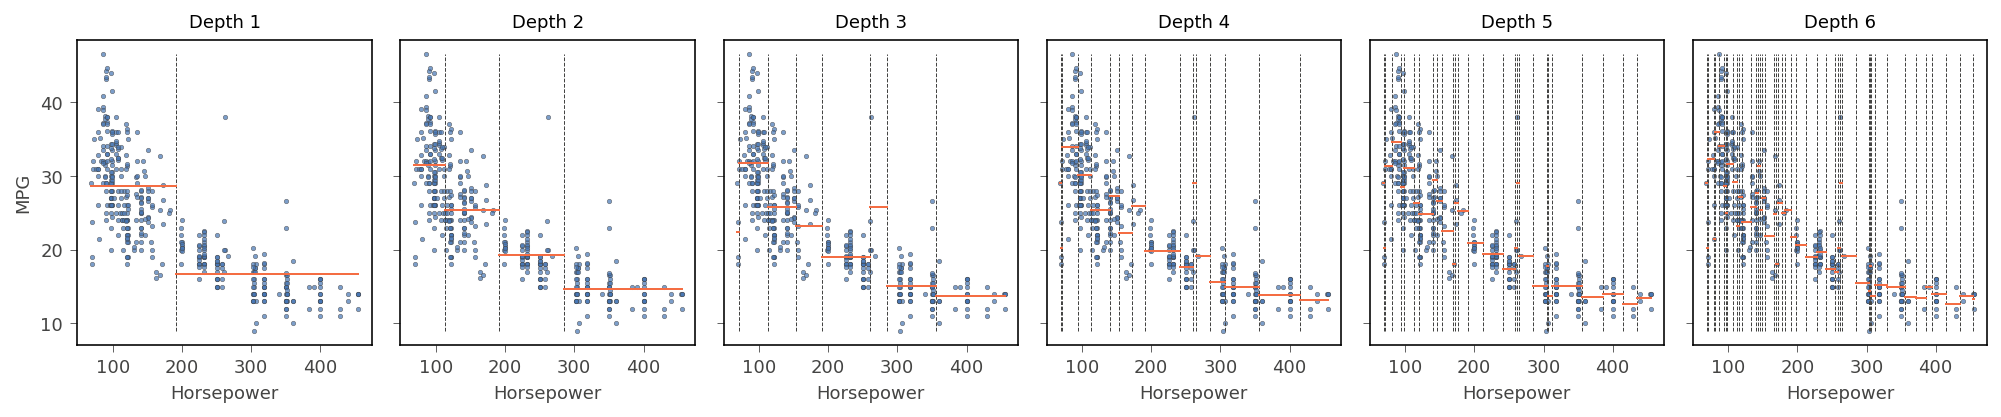

In [7]:
X = df_cars[['ENG']].values
y = df_cars['MPG'].values

fig, axes = plt.subplots(1,6, figsize=(14,3), sharey=True)
for i,ax in enumerate(axes.flatten()):
    dt = DecisionTreeRegressor(max_depth=i+1)
    dt.fit(X, y)
    t = rtreeviz_univar(dt,
                        X, y,
                        feature_names='Horsepower',
                        markersize=5,
                        mean_linewidth=1,
                        target_name='MPG' if i==0 else None,
                        fontsize=9,
                        show={'splits'},
                        ax=ax)
    ax.set_title(f"Depth {i+1}", fontsize=9)
plt.tight_layout()
plt.show()

**Q.** Focusing on the orange horizontal lines, what do you notice as more splits appear?

<details>
<summary>Solution</summary>
With depth 1, model is biased due to coarseness of the approximations (just 2 leaf means).  Depth 2 gets much better approximation, so bias is lower. As we add more depth to tree, number of splits increases and these appear to be chasing details of the data, decreasing bias on training set but also hurting generality.
</details>


**Q.** Consider the MSE for the 4 leaves of a depth 2 tree and 15 leaves of a depth 4 tree.  What happens to the average MSE per leaf?  What happens to the leaf sizes and how is it related to average MSE?

In [8]:
show_mse_leaves(df_cars[['ENG']], df_cars['MPG'], max_depth=2)

Root   0 has 392 samples with MSE = 99.90
-----------------------------------------
Node   2 has 120 samples with MSE = 30.45
Node   3 has 102 samples with MSE = 20.07
Node   5 has  72 samples with MSE =  9.23
Node   6 has  98 samples with MSE =  6.76
Average MSE per record is 17.9


In [9]:
show_mse_leaves(df_cars[['ENG']], df_cars['MPG'], max_depth=4)

Root   0 has 392 samples with MSE = 99.90
-----------------------------------------
Node   4 has   1 samples with MSE =  0.00
Node   5 has   3 samples with MSE =  6.18
Node   7 has  51 samples with MSE = 29.27
Node   8 has  65 samples with MSE = 20.59
Node  11 has  68 samples with MSE = 20.26
Node  12 has  16 samples with MSE =  9.32
Node  14 has  13 samples with MSE = 23.93
Node  15 has   5 samples with MSE =  3.21
Node  19 has  44 samples with MSE =  2.91
Node  20 has  25 samples with MSE =  4.35
Node  22 has   2 samples with MSE = 81.00
Node  23 has   1 samples with MSE =  0.00
Node  26 has  22 samples with MSE =  6.03
Node  27 has  47 samples with MSE =  8.26
Node  29 has  20 samples with MSE =  3.81
Node  30 has   9 samples with MSE =  1.51
Average MSE per record is 14.6


<details>
<summary>Solution</summary>
The average MSE is much lower as we increase depth because that allows the tree to isolate pure/more-similar regions.  This also shrinks leaf size since we are splitting more as the tree deepens.
</details>


Consider the plot of the CYL feature (num cylinders) vs MPG:

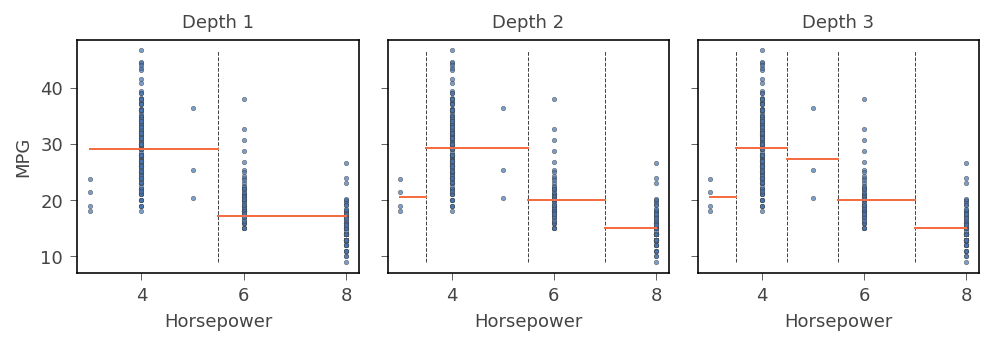

In [10]:
X = df_cars[['CYL']].values
y = df_cars['MPG'].values

fig, axes = plt.subplots(1,3, figsize=(7,2.5), sharey=True)
depths = [1,2,10]
for i,ax in enumerate(axes.flatten()):
    dt = DecisionTreeRegressor(max_depth=depths[i])
    dt.fit(X, y)
    t = rtreeviz_univar(dt,
                        X, y,
                        feature_names='Horsepower',
                        markersize=5,
                        mean_linewidth=1,
                        target_name='MPG' if i==0 else None,
                        fontsize=9,
                        show={'splits','title'},
                        ax=ax)
    ax.set_title(f"Depth {i+1}", fontsize=9)
plt.tight_layout()
plt.show()

**Q.** Explain why the graph looks like a bunch of vertical bars.

<details>
<summary>Solution</summary>
The x values are integers and will clump together. Since there are many MPG values at each int, you get vertical clumps of data.
</details>

**Q.** Why don't we get many more splits for depth 10 vs depth 2?

<details>
<summary>Solution</summary>
Once each unique x value has a "bin", there are no more splits to do.
</details>

**Q.** Why are the orange predictions bars at the levels they are in the plot?

<details>
<summary>Solution</summary>
Decision tree leaves predict the average y for all samples in a leaf.
</details>

## Classification

In [11]:
wine = load_wine()
df_wine = pd.DataFrame(data=wine.data, columns=wine.feature_names)
df_wine.head(3)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0


In [12]:
feature_names = list(wine.feature_names)
class_names = list(wine.target_names)

### 1 variable

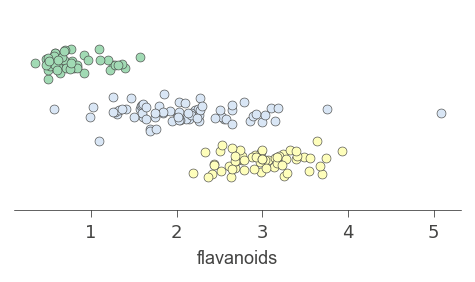

In [13]:
X = df_wine[['flavanoids']].values
y = wine.target

dt = DecisionTreeClassifier(max_depth=1)
dt.fit(X, y)

fig, ax = plt.subplots(1,1, figsize=(4,1.8))
ct = ctreeviz_univar(dt, X, y,
                     feature_names = 'flavanoids',
                     class_names=class_names,
                     target_name='Wine',
                     nbins=40, gtype='strip',
                     fontsize=9,
                     show={},
                     colors={'scatter_marker_alpha':1, 'scatter_marker_alpha':1},
                     ax=ax)
plt.show()

**Q.** Where would you split this (vertically) if you could only split once?

<details>
<summary>Solution</summary>
The split location that gets most pure subregion might be about 1.5 because it nicely carves off the left green samples.
</details>

**Alter the code to show the split with arg show={'splits'}**

<details>
<summary>Solution</summary>
<pre>
X = df_wine[['flavanoids']].values
y = wine.target

dt = DecisionTreeClassifier(max_depth=1)
dt.fit(X, y)

fig, ax = plt.subplots(1,1, figsize=(4,1.8))
ct = ctreeviz_univar(dt, X, y,
                     feature_names = 'flavanoids',
                     class_names=class_names,
                     target_name='Wine',
                     nbins=40, gtype='strip',
                     fontsize=9,
                     show={'splits'},
                     colors={'scatter_marker_alpha':1, 'scatter_marker_alpha':1},
                     ax=ax)
plt.show()
</pre>
</details>

**Q.** For max_depth=2, how many splits will we get?

<details>
<summary>Solution</summary>
3. We get one split for root and then with depth=2, we have 2 children that each get a split.
</details>

**Q.** Where would you split this graph in that many places?

<details>
<summary>Solution</summary>
Once we carve off the leftmost green, we would want to isolate the blue in between 1.3 and 2.3.  The other place to split is not obvious as there is no great choice. (sklearn will add a split point at 1.0)
</details>


**Alter the code to show max_depth=2**

<details>
<summary>Solution</summary>
<pre>
X = df_wine[['flavanoids']].values
y = wine.target

dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X, y)

fig, ax = plt.subplots(1,1, figsize=(4,1.8))
ct = ctreeviz_univar(dt, X, y,
                     feature_names = 'flavanoids',
                     class_names=class_names,
                     target_name='Wine',
                     nbins=40, gtype='strip',
                     fontsize=9,
                     show={'splits'},
                     colors={'scatter_marker_alpha':1, 'scatter_marker_alpha':1},
                     ax=ax)
plt.show()
</pre>
</details>

### Gini impurity

Let's compute the gini impurity for left and right sides for a depth=1 tree that splits flavanoids at 1.3. Here's a function that computes the value:

$$
Gini({\bf p}) = \sum_{i=1}^{k} p_i \left[ \sum_{j \ne i}^k p_j \right] = \sum_{i=1}^{k} p_i (1 - p_i) = 1 - \sum_{i=1}^{k} p_i^2
$$

where $p_i = \frac{|y[y==i]|}{|y|}$. Since $\sum_{j \ne i}^k p_j$ is the probability of "not $p_i$", we can summarize that as just $1-p_i$. The gini value is then computing $p_i$ times "not $p_i$" for $k$ classes.  Value $p_i$ is the probability of seeing class $i$ in a list of target values, $y$. 

In [14]:
def gini(y):
    """
    Compute gini impurity from y vector of class values (from k unique values).
    Result is in range 0..(k-1/k) inclusive; binary range is 0..1/2.
    See https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity"
    """
    _, counts = np.unique(y, return_counts=True)
    p = counts / len(y)
    return 1 - np.sum( p**2 )

**Q.** Using that function, what is the gini impurity for the overall y target

<details>
<summary>Solution</summary>
gini(y) # about 0.66
</details>


**Get all y values for rows where `df_wine['flavanoids']`<1.3 into variable `lefty` and `>=` into `righty`**

In [15]:
lefty = ...
righty = ...

<details>
<summary>Solution</summary>
<pre>
lefty = y[df_wine['flavanoids']&lt;1.3]
righty = y[df_wine['flavanoids']&gt;=1.3]
</pre>
</details>


**Q.** What are the gini values for left and right partitions?

<details>
<summary>Solution</summary>
gini(lefty), gini(righty) # about 0.27, 0.53
</details>

**Q.** What can we conclude about the purity of left and right? Also, compare to gini  for all y values.

<details>
<summary>Solution</summary>
Left partition is much more pure than right but right is still more pure than original gini(y). We can conclude that the split is worthwhile as the partition would let us give more accurate predictions.
</details>

### 2 variables

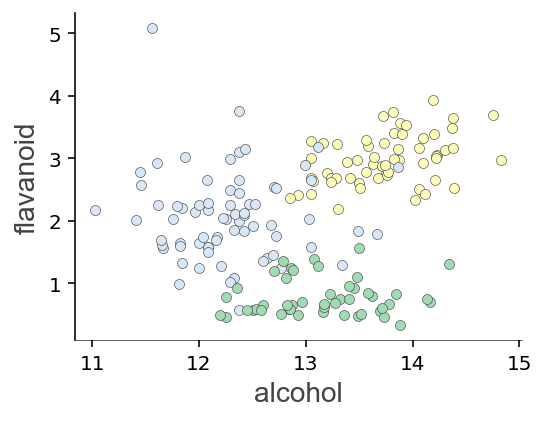

In [16]:
X = df_wine[['alcohol','flavanoids']].values
y = wine.target

dt = DecisionTreeClassifier(max_depth=1)
dt.fit(X, y)

fig, ax = plt.subplots(1, 1, figsize=(4,3))
ct = ctreeviz_bivar(dt, X, y,
                     feature_names = ['alcohol','flavanoid'], class_names=class_names,
                     target_name='iris',
                     show={},
                     colors={'scatter_marker_alpha':1, 'scatter_marker_alpha':1},
                     ax=ax
                   )

**Q.** Which variable and split point would you choose if you could only split once?

<details>
<summary>Solution</summary>
Because the blue dots are spread vertically, a horizontal split won't be very good. Hence, we should choose variable proline.  The best split will carve off the blue dots, leaving the yellow and green mixed up.  A split at proline=12.7 seems pretty good.
</details>


**Modify the code to view the splits and compare your answer**

**Q.** Which variable and split points would you choose next for depth=2?

<details>
<summary>Solution</summary>
Once we carve off most of the blue vertically, we should separate the yellow by choosing flavanoid=1.7 to split horizontally. NOTICE, however, that the 2nd split will not be across entire graph since we are splitting the region on the right.  Splitting on the left can be at flavanoid=1 so we isolate the green from blue on left.
</details>


**Modify the code to view the splits for depth=2 and compare your answer**

### Gini

Let's examine gini impurity for a different pair of variables.

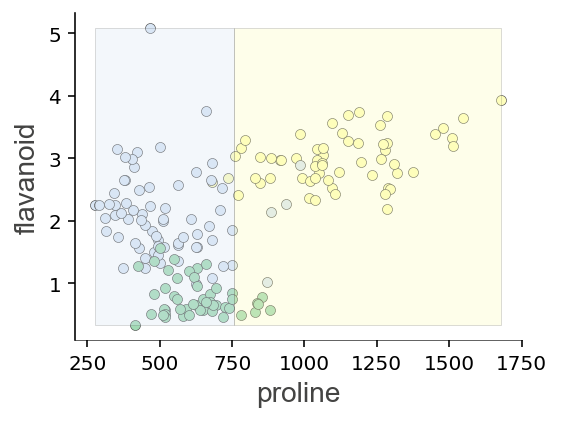

In [17]:
X = df_wine[['proline','flavanoids']].values
y = wine.target

dt = DecisionTreeClassifier(max_depth=1)
dt.fit(X, y)

fig, ax = plt.subplots(1, 1, figsize=(4,3))
ctreeviz_bivar(dt, X, y,
               feature_names = ['proline','flavanoid'],
               class_names=class_names,
               target_name='iris',
               show={'splits'},
               colors={'scatter_marker_alpha':1, 'scatter_marker_alpha':1},
               ax=ax)
plt.show()

**Get all y values for rows where the split var is less than the split value into variable `lefty` and those `>=` into `righty`**

In [18]:
lefty = ...
righty = ...

<details>
<summary>Solution</summary>
<pre>
lefty = y[df_wine['proline']&lt;750]
righty = y[df_wine['proline']&gt;=750]
</pre>
</details>


**Print out the gini for y, lefty, righty**

<details>
<summary>Solution</summary>
<pre>
gini(y), gini(lefty), gini(righty)
</pre>
</details>


## Training a single tree and print out the training accuracy (num correct / total)

In [19]:
t = DecisionTreeClassifier()
t.fit(df_wine, y)
accuracy_score(y, t.predict(df_wine))

1.0

Take a look at the feature importance:

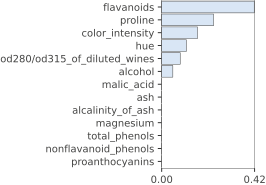

In [20]:
from rfpimp import *
I = importances(t, df_wine, y)
plot_importances(I)